In [109]:
import os 
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Sequence, Literal
from pydantic import BaseModel, Field

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate
from langchain import hub

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [110]:
groq_api_key = os.getenv('GROQ_API_KEY')
llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [111]:
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

embeddings = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

In [112]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]

doc_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=50)
documents = doc_splitter.split_documents(docs_list)

vectordb = Chroma.from_documents(
    documents=documents, collection_name="agentic-rag", embedding=embeddings
)

retriever = vectordb.as_retriever()

In [113]:
retriever.get_relevant_documents("about prompt engineering")

[Document(metadata={'language': 'en', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'title': "Prompt Engineering | Lil'Log", 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/'}, page_content="Prompt Engineering | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\

In [114]:
retriever_tool = create_retriever_tool(
    retriever,
    name="retriever-blog-tool",
    description="Search and retrun information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs. You are a specialized assistant. \
        Use the 'retriever_tool' **only** when the query explicitly related to Langchain blog data. For all other queries, respond directly without using any tool.\
            For any simple quieries 'hi', 'hello', or 'how are you', provide a normal response."
)

In [115]:
tools = [retriever_tool]

In [116]:
retrieve = ToolNode([retriever_tool])

In [117]:
llm_with_tools = llm.bind_tools(tools)

In [118]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [119]:
def ai_assistant(state):
    print("---CALL AGENT---")
    question = state['messages'][0].content
    
    return {"messages": [llm_with_tools.invoke(question)]}

In [120]:
class Grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

In [121]:
def grade_documents(state: AgentState) -> Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op = llm.with_structured_output(Grade)
    
    template = """ 
    You are a helpful assistant tasked with identify provided content is relevant to the question or not.
    content: {content}
    question: {question}
    provide the answer in 'yes' or 'no'
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["context", "question"]
    )
    
    rag_chain = prompt | llm_with_structure_op
    
    question = state['messages'][0].content
    last_message = state['messages'][-1]
    docs = last_message.content
    
    scored_result = rag_chain.invoke({"content": docs, "question": question})
    score = scored_result.binary_score 
    
    if score == 'yes':
        print("---DECISION: DOCS RELEVANT---")
        return "generator"
    else:
        print("---DECISION: DOCS NOT RELEVANT")
        return "rewriter"

In [122]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state['messages']
    
    question = messages[0].content 
    docs = messages[-1].content 
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm 
    
    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"This is my response : {response}")
    
    return {"messages": [response]}

In [123]:
from langchain_core.messages import HumanMessage

def rewrite(state: AgentState):
    print("---TRANSFORM QUERY---")
    
    question = state['messages'][0].content 
    
    message = HumanMessage(content=f"Look at the input and try to reason about the underlying semantic intent or meaning. \
        Here is the initial question: {question}\
        Formulate an improved question.")
    
    response = llm.invoke(message)
    return {"messages": [response]}

In [124]:
workflow = StateGraph(AgentState)

workflow.add_node("My_Ai_Assistant", ai_assistant)
workflow.add_node("Vector_Retriever", retrieve)
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite)

workflow.add_edge(START, "My_Ai_Assistant")

workflow.add_conditional_edges(
    "My_Ai_Assistant",
    tools_condition,
    {
        "tools": "Vector_Retriever",
        END: END
    }
)

workflow.add_conditional_edges(
    "Vector_Retriever",
    grade_documents,
    {
        "generator": "Output_Generator",
        "rewriter": "Query_Rewriter"
    }
)


workflow.add_edge("Output_Generator", END)
workflow.add_edge("Query_Rewriter", "My_Ai_Assistant")

app = workflow.compile()

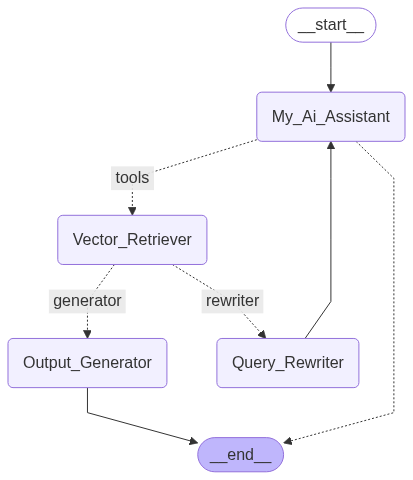

In [125]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [126]:
app.invoke({"messages": ["What is a Autonomous Agent?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='c8f61f24-29b2-4a27-9d8e-be8a6a7f5c90'),
  AIMessage(content="An autonomous agent is a system or entity that can perform tasks independently without human intervention. It has the ability to perceive its environment, make decisions, and take actions based on its own goals and objectives. Autonomous agents can be found in various fields, including robotics, artificial intelligence, and computer science.\n\nAutonomous agents typically have the following characteristics:\n\n1. Autonomy: They can operate independently without human control.\n2. Reactivity: They can respond to changes in their environment.\n3. Proactivity: They can take initiative to achieve their goals.\n4. Social ability: They can interact with other agents or systems.\n\nExamples of autonomous agents include:\n\n1. Self-driving cars\n2. Drones\n3. Robots\n4. Chatbots\n5. Virtual assistants\n\nIn the context of